### Imports

In [4]:
from skimage.io import imread
from skimage.filters import gaussian
import numpy as np
from matplotlib import pyplot as plt
from skimage import img_as_float
import math

# Find best image differencing parameters.

In [5]:
im1 = imread('./data/aerobic-001.bmp')
im1 = img_as_float(im1)
im2 = imread('./data/aerobic-002.bmp')
im2 = img_as_float(im2)

## Simple Image Difference

$\Delta I = 1 \text{ if } |I_t - I_{t-1}| > \tau$

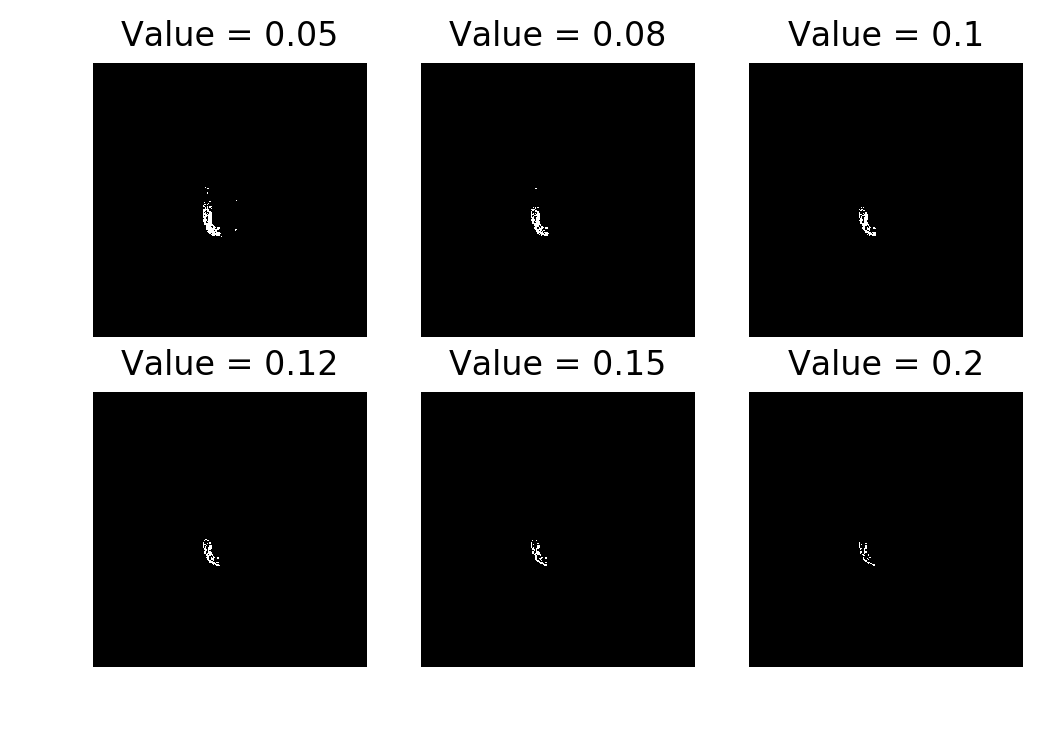

In [9]:
threshLevels = [0.05, 0.08, 0.10, 0.12, 0.15, 0.2]
f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', dpi=200)
for thresh in threshLevels:
    magIm = np.abs(im1 - im2)
    tImg = magIm > thresh
    idx = threshLevels.index(thresh)
    #print((int(idx/3), idx%3))
    axarr[int(idx/3), idx%3].axis('off')
    axarr[int(idx/3), idx%3].set_title(f'Value = {thresh}')
    axarr[int(idx/3), idx%3].imshow(tImg, cmap = 'gray', aspect='auto')

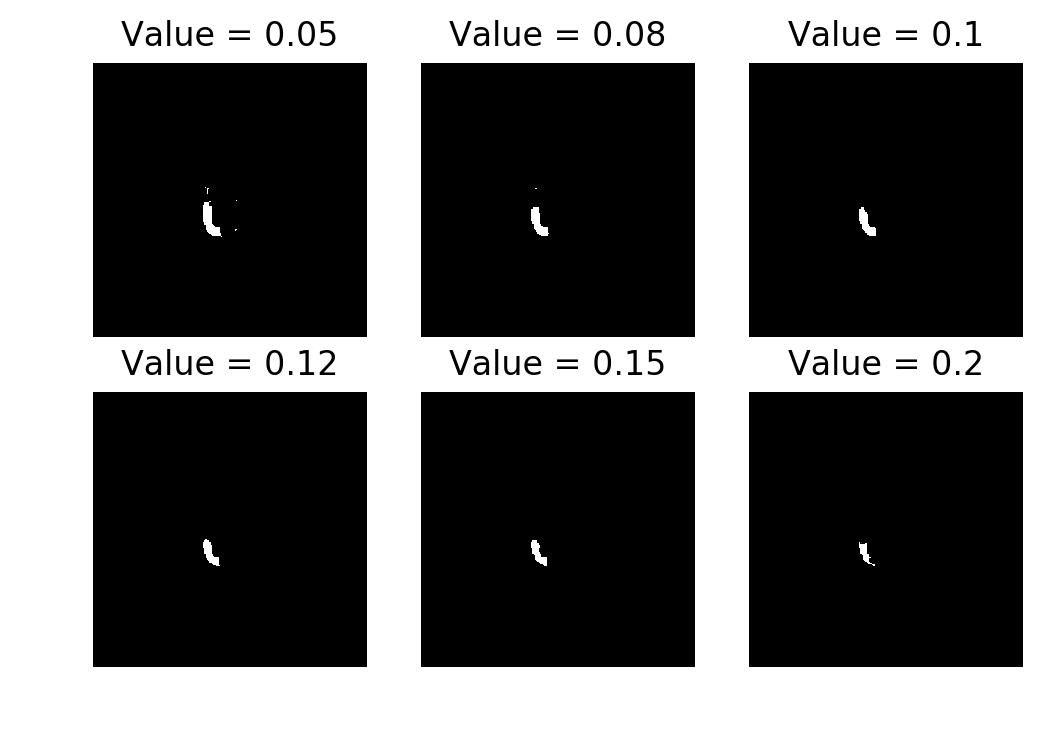

In [20]:
from skimage.morphology import closing
from skimage.morphology import opening
from skimage.morphology import dilation
from skimage.morphology import square

threshLevels = [0.05, 0.08, 0.10, 0.12, 0.15, 0.2]
f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', dpi=200)
for thresh in threshLevels:
    magIm = np.abs(im1 - im2)
    magIm = closing(magIm, square(5))
    tImg = magIm > thresh
    idx = threshLevels.index(thresh)
    #print((int(idx/3), idx%3))
    axarr[int(idx/3), idx%3].axis('off')
    axarr[int(idx/3), idx%3].set_title(f'Value = {thresh}')
    axarr[int(idx/3), idx%3].imshow(tImg, cmap = 'gray', aspect='auto')


# Perform Motion History Imaging and Motion Energy Imaging using the best differencing technique

In [184]:
aer_cube = []

for i in range(1,23):
    tmp = imread('./data/aerobic-{:03}.bmp'.format(i))
    tmp = img_as_float(tmp)
    aer_cube.append(tmp)
    
aer_cube=np.array(aer_cube)

In [186]:
aer_cube.shape

aer_cube[0].max()

0.792156862745098

In [325]:
aer_diff = np.abs(aer_cube[1:,:,:] - aer_cube[:-1,:,:])

for i in range(aer_diff.shape[0]):
    aer_diff[i] = closing(aer_diff[i], square(5)) > 0.08

In [326]:
MEI = [aer_diff[:i, :, :].sum(axis=0) for i in range(1, T)]

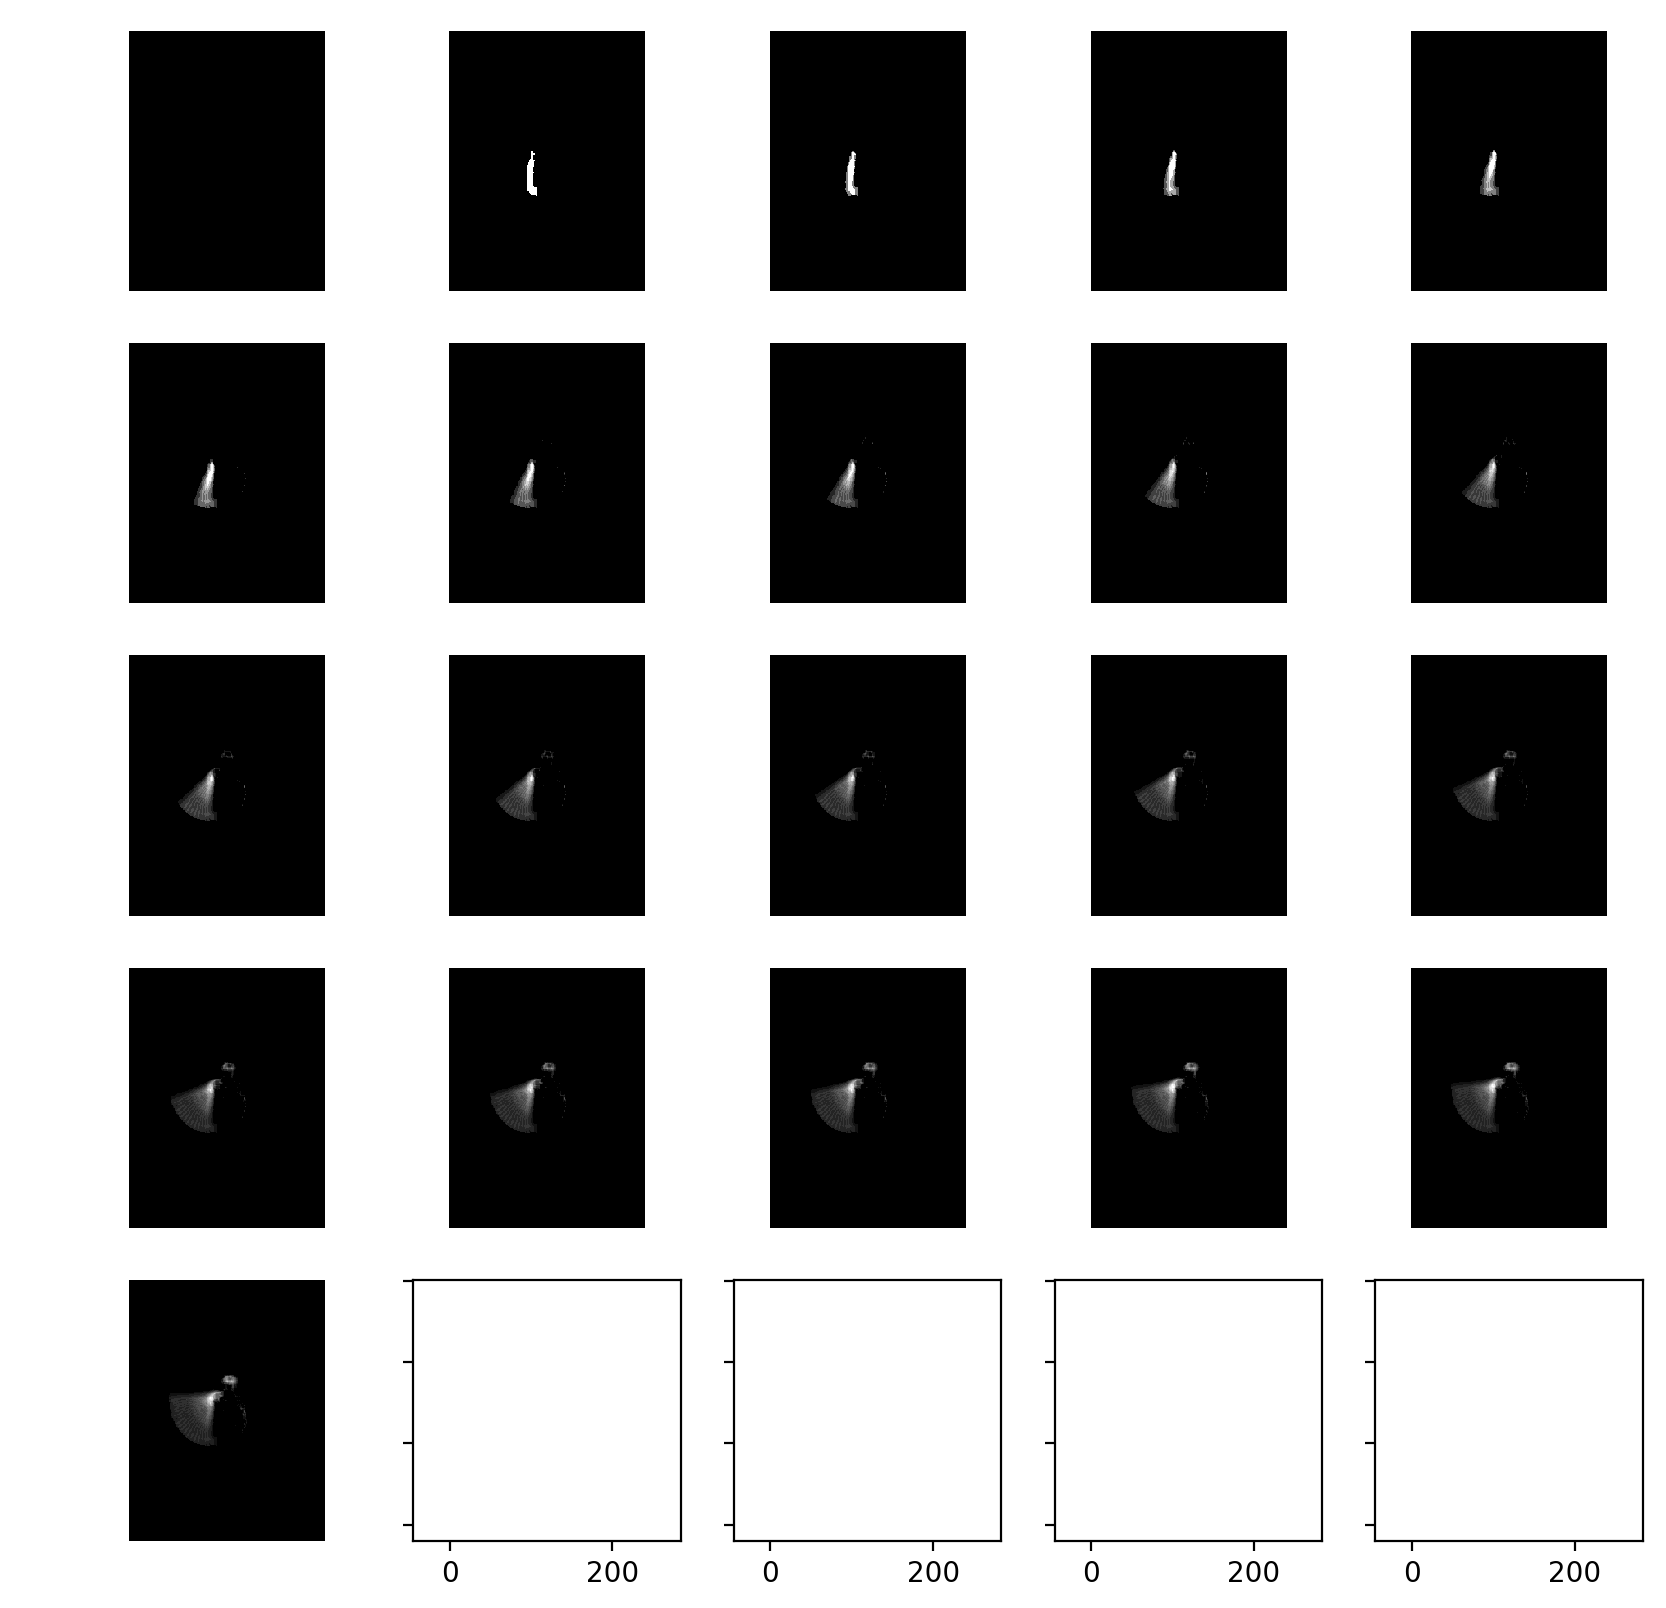

In [332]:
f, axarr = plt.subplots(5, 5, sharex='col', sharey='row', dpi=200, figsize=(10,10))
for idx in range(0, 21):
    axarr[int(idx/5), idx%5].axis('off')
    axarr[int(idx/5), idx%5].imshow(MEI[idx], cmap = 'gray')

In [328]:
MHI = [aer_diff[i, :, :]*i for i in range(0, T-1)]

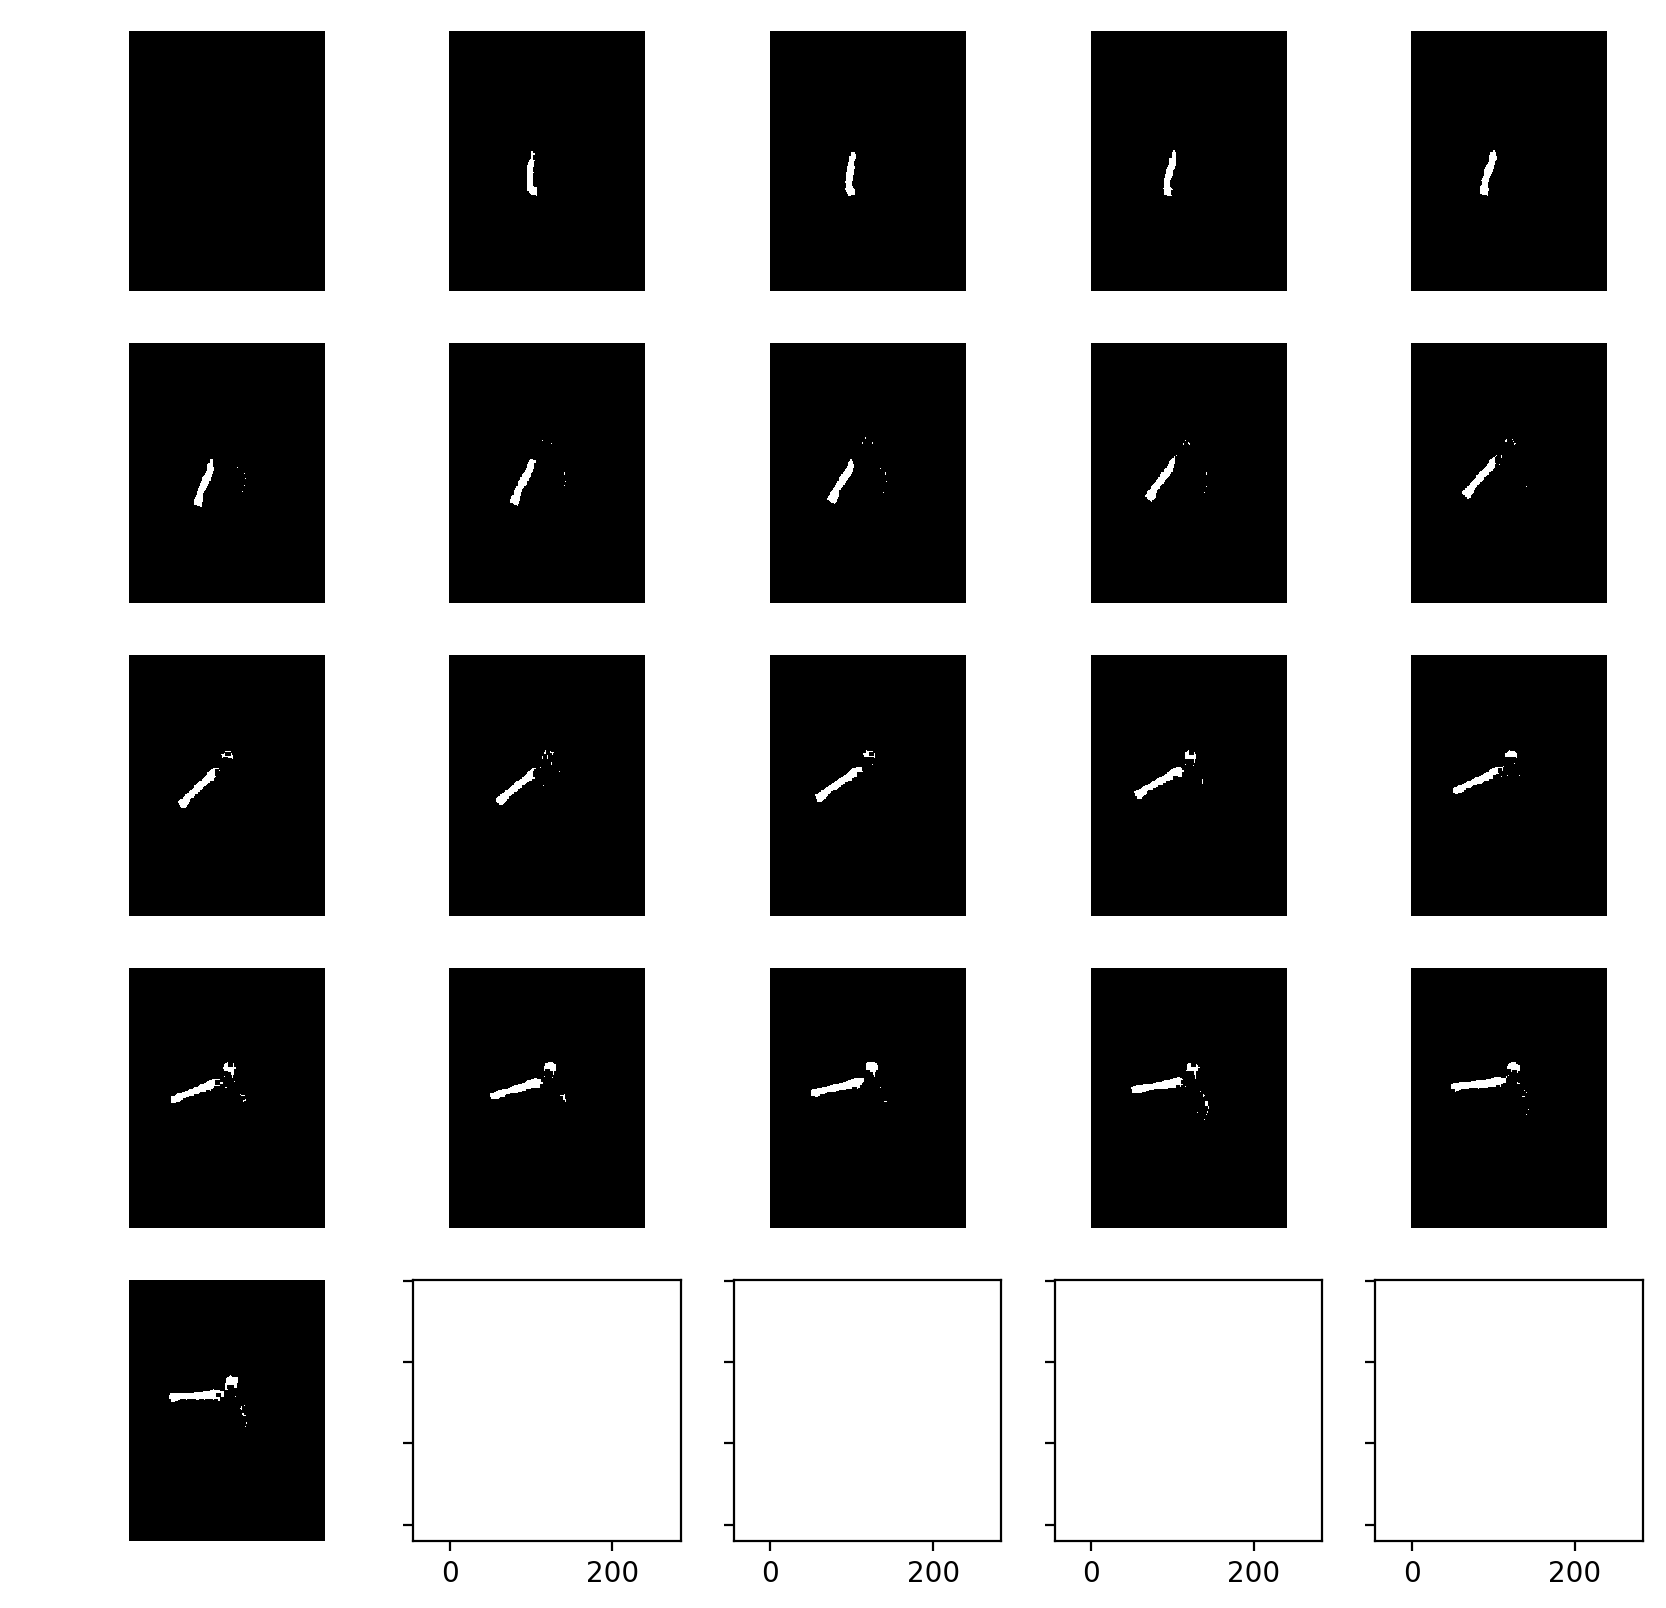

In [333]:
f, axarr = plt.subplots(5, 5, sharex='col', sharey='row', dpi=200, figsize=(10,10))
for idx in range(0, 21):
    axarr[int(idx/5), idx%5].axis('off')
    axarr[int(idx/5), idx%5].imshow(MHI[idx], cmap = 'gray')

# Perform Optic Flow on the set of images using the best differencing technique

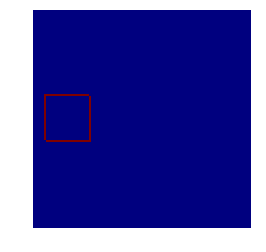

In [176]:
box1 = np.zeros((101,101))
box2 = np.zeros((101,101))

size = 21
box1[39:39+size, 5:5+size] = 1
box2[40:40+size, 6:6+size] = 1

box1 = img_as_float(box1)
box2 = img_as_float(box2)

plt.axis('off')
plt.imshow(np.abs(box2-box1), cmap='jet')

In [150]:
from scipy import signal
def optical_flow(I1g, I2g, window_size):
 
    kernel_x = 0.25 * np.array([[-1., 1.], [-1., 1.]])
    kernel_y = 0.25 * np.array([[-1., -1.], [1., 1.]])
    kernel_t = 0.25 * np.array([[1., 1.], [1., 1.]])
    kernel_x = np.fliplr(kernel_x)
    mode = 'same'
    fx = (signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode))
    fy = (signal.convolve2d(I1g, kernel_y, boundary='symm', mode=mode))
    ft = (signal.convolve2d(I2g, kernel_t, boundary='symm', mode=mode) + 
         signal.convolve2d(I1g, -kernel_t, boundary='symm', mode=mode))
        
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    
    window = np.ones((window_size,window_size))
    
    denom = (signal.convolve2d(fx**2, window, boundary='symm', mode=mode) * 
            signal.convolve2d(fy**2, window, boundary='symm', mode=mode) -
            signal.convolve2d(fx*fy, window, boundary='symm', mode=mode)**2)
    denom[denom == 0] = np.inf
    
    u = ((signal.convolve2d(fy**2, window, boundary='symm', mode=mode) * 
             signal.convolve2d(fy*ft, window, boundary='symm', mode=mode) + 
             signal.convolve2d(fx*fy, window, boundary='symm', mode=mode) * 
             signal.convolve2d(fy*ft, window, boundary='symm', mode=mode) ) /
        denom)
    
    
    v = ((signal.convolve2d(fx*ft, window, boundary='symm', mode=mode) * 
             signal.convolve2d(fx*fy, window, boundary='symm', mode=mode) -
             signal.convolve2d(fx**2, window, boundary='symm', mode=mode) * 
             signal.convolve2d(fy*ft, window, boundary='symm', mode=mode)) / 
        denom)
    
 
    return (u,v)

u,v = optical_flow(box1, box2, 3)

In [151]:
x = np.arange(0, box1.shape[1], 1)
y = np.arange(0, box1.shape[0], 1)
x, y = np.meshgrid(x, y)
delta = 3

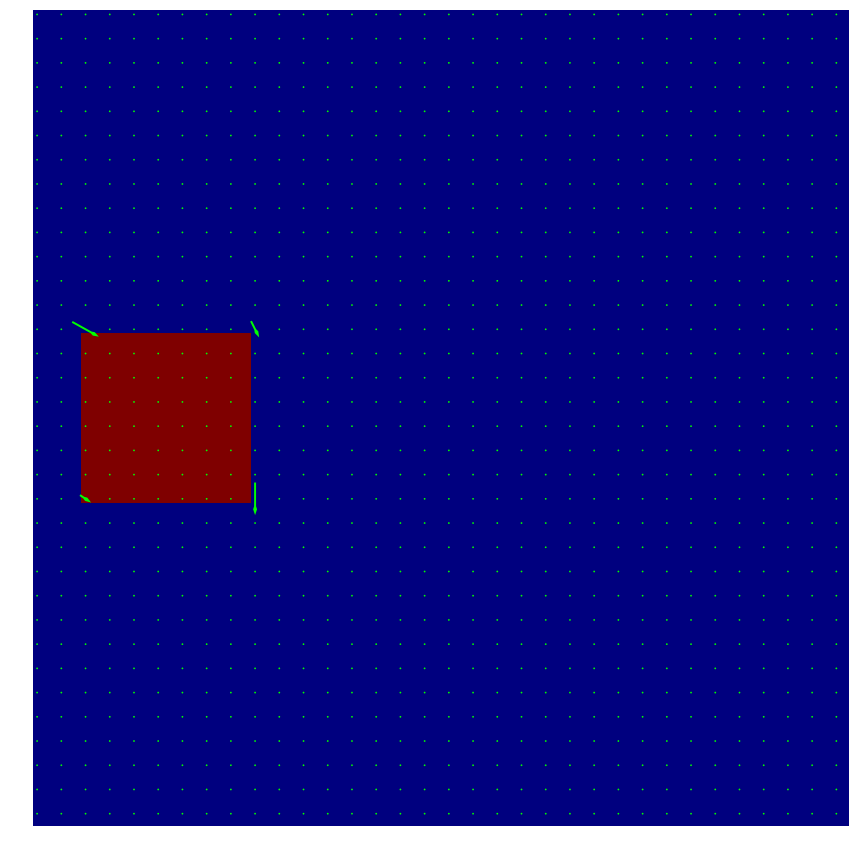

In [178]:
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(box2, cmap='jet')
plt.quiver(x[::delta, ::delta], y[::delta, ::delta],
           u[::delta, ::delta], v[::delta, ::delta],
color='lime', pivot='middle', headwidth=2, headlength=3, scale=50)

# Bonus: MHI and MEI using Silhouettes (generated background using clone stamping)